## Image Captioning using KNN

Although VLMs (Vision Language Models) are the go to tools for image captioning right now, there are interesting works from earlier years that used KNN for captioning and perform surprisingly well enough!

Further, Libraries like [Faiss](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) perform the nearest neighbor computation efficiently and are used in many industrial applications.

- In this question you will implement an algorithm to perform captioning using KNN based on the paper [A Distributed Representation Based Query Expansion Approach for
Image Captioning](https://aclanthology.org/P15-2018.pdf)

- Dataset: [MS COCO](https://cocodataset.org/#home) 2014 (val set only)

- Algorithm:
    1. Given: Image embeddings and correspond caption embeddings (5 Per image)
    1. For every image, findout the k nearest images and compute its query vector as the weighted sum of the captions of the nearest images (k*5 captions per image)
    1. The predicted caption would be the caption in the dataset that is closest to the query vector. (for the sake of the assignment use the same coco val set captions as the dataset)

- The image and text embeddings are extracted from the [CLIP](https://openai.com/research/clip) model. (You need not know about this right now)

- Tasks:
    1. Implement the algorithm and compute the bleu score. Use Faiss for nearest neighbor computation. Starter code is provided below.
    1. Try a few options for k. Record your observations.
    1. For a fixed k, try a few options in the Faiss index factory to speed the computation in step 2. Record your observations.
    1. Qualitative study: Visualize five images, their ground truth captions and the predicted caption.
    
Note: Run this notebook on Colab for fastest resu

In [1]:
!gdown 1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO #image embeddings

Downloading...
From: https://drive.google.com/uc?id=1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO
To: /content/coco_imgs.npy
100% 83.0M/83.0M [00:01<00:00, 66.0MB/s]


In [2]:
!gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW #caption embeddings

Downloading...
From (original): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW
From (redirected): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW&confirm=t&uuid=d89c4812-5556-42d4-bb25-e93b968731cc
To: /content/coco_captions.npy
100% 415M/415M [00:11<00:00, 35.8MB/s]


In [3]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip /content/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
!pip install faiss-cpu

Streaming output truncated to the last 5000 lines.
 extracting: val2014/COCO_val2014_000000376046.jpg  
 extracting: val2014/COCO_val2014_000000066394.jpg  
 extracting: val2014/COCO_val2014_000000277584.jpg  
 extracting: val2014/COCO_val2014_000000383518.jpg  
 extracting: val2014/COCO_val2014_000000262466.jpg  
 extracting: val2014/COCO_val2014_000000153055.jpg  
 extracting: val2014/COCO_val2014_000000155312.jpg  
 extracting: val2014/COCO_val2014_000000010440.jpg  
 extracting: val2014/COCO_val2014_000000541108.jpg  
 extracting: val2014/COCO_val2014_000000202503.jpg  
 extracting: val2014/COCO_val2014_000000161308.jpg  
 extracting: val2014/COCO_val2014_000000153013.jpg  
 extracting: val2014/COCO_val2014_000000089924.jpg  
 extracting: val2014/COCO_val2014_000000289842.jpg  
 extracting: val2014/COCO_val2014_000000191226.jpg  
 extracting: val2014/COCO_val2014_000000157465.jpg  
 extracting: val2014/COCO_val2014_000000218224.jpg  
 extracting: val2014/COCO_val2014_000000030548.j

In [4]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
import faiss
import numpy as np

In [5]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(), 
        transforms.Normalize(
            (0.485, 0.456, 0.406),  
            (0.229, 0.224, 0.225),
        )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3] # load 4th sample

print("Image Size: ", img.shape)
print(target)

loading annotations into memory...
Done (t=1.44s)
creating index...
index created!
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']


In [6]:
ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) 
captions_np = np.array(captions)
print('Captions:', captions_np.shape)

Captions: (40504, 5)


In [18]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))
print(captions_flat[:3])

Total captions: 202520
['This wire metal rack holds several pairs of shoes and sandals', 'A dog sleeping on a show rack in the shoes.', 'Various slides and other footwear rest in a metal basket outdoors.']


In [8]:
cap_path = 'coco_captions.npy'
caption_embeddings = np.load(cap_path)
print('Caption embeddings',caption_embeddings.shape)

Caption embeddings (40504, 5, 512)


In [9]:
img_path = '/content/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings',image_embeddings.shape)

Image embeddings (40504, 512)


In [ ]:
def accuracy(predict, real)
    accuracy = 0
    for i, pre in enumerate(predict):
        references = real[i]
        score = bleu_score.sentence_bleu(references, pre)
        accuracy += score
    return accuracy/len(predict)

In [48]:
import numpy as np
import faiss
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

image_embeddings_norm = image_embeddings / np.linalg.norm(image_embeddings, axis=1, keepdims=True)
caption_embeddings_flat = caption_embeddings.reshape(-1, 512)
caption_embeddings_norm_flat = caption_embeddings_flat / np.linalg.norm(caption_embeddings_flat, axis=1, keepdims=True)

image_index = faiss.IndexFlatIP(512)
image_index.add(image_embeddings_norm.astype('float32'))

k = 10
D, I = image_index.search(image_embeddings_norm.astype('float32'), k + 1)

query_vectors = np.zeros_like(image_embeddings_norm)
for i, (indices, distances) in enumerate(zip(I, D)):
    indices = indices[1:]
    cosine_similarities = 1 - distances[1:] / 2

    weighted_caption_sums = np.zeros((512,))
    for idx, cos_sim in zip(indices, cosine_similarities):
        neighbor_captions = caption_embeddings_norm_flat[idx * 5: idx * 5 + 5]

        weighted_caption_sums += neighbor_captions.sum(axis=0) * cos_sim

    query_vectors[i] = weighted_caption_sums / (k * 5 * np.sum(cosine_similarities))

caption_index = faiss.IndexFlatIP(512)
caption_index.add(caption_embeddings_norm_flat.astype('float32'))

_, predicted_indices = caption_index.search(query_vectors.astype('float32'), 1)

predicted_captions_text = [captions_flat[index] for index in predicted_indices.flatten()]



In [52]:
smoothing = SmoothingFunction()
bleu_scores = []

for i, pred_caption_text in enumerate(predicted_captions_text):
    img_id = coco_dset.ids[i]
    ann_ids = coco_dset.coco.getAnnIds(imgIds=img_id)
    annotations = coco_dset.coco.loadAnns(ann_ids)
    references = [ann['caption'].split() for ann in annotations]
    candidate = pred_caption_text.split()
    score = sentence_bleu(references, candidate, smoothing_function=SmoothingFunction().method1)
    bleu_scores.append(score)

average_bleu_score = np.mean(bleu_scores)
print(f"Average BLEU Score: {average_bleu_score}")


Average BLEU Score: 0.14401773862979894


for k =3, average bleu score is = 0.14592763552918497

for k =5, average bleu score is = 0.14622974312374487

for k =10, average bleu score is = 0.14401773862979894

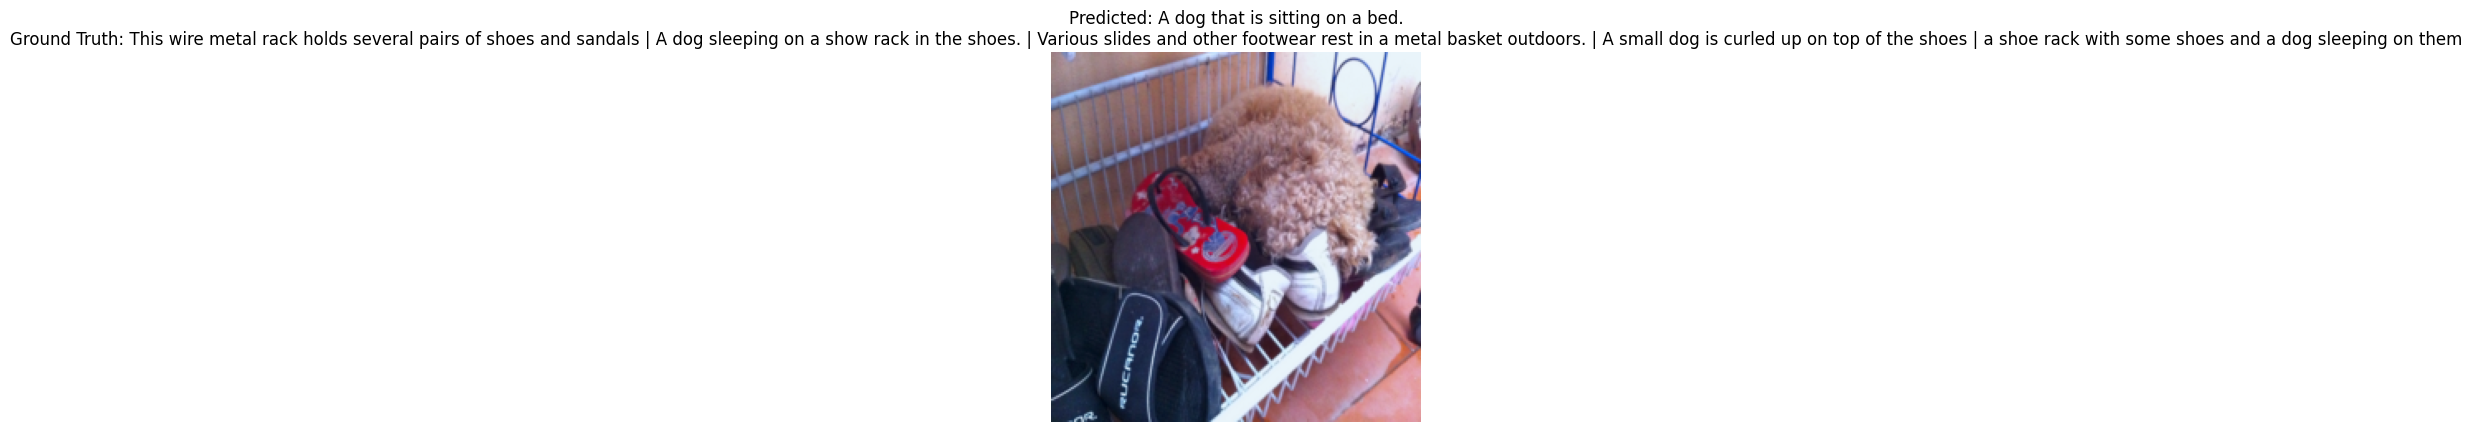

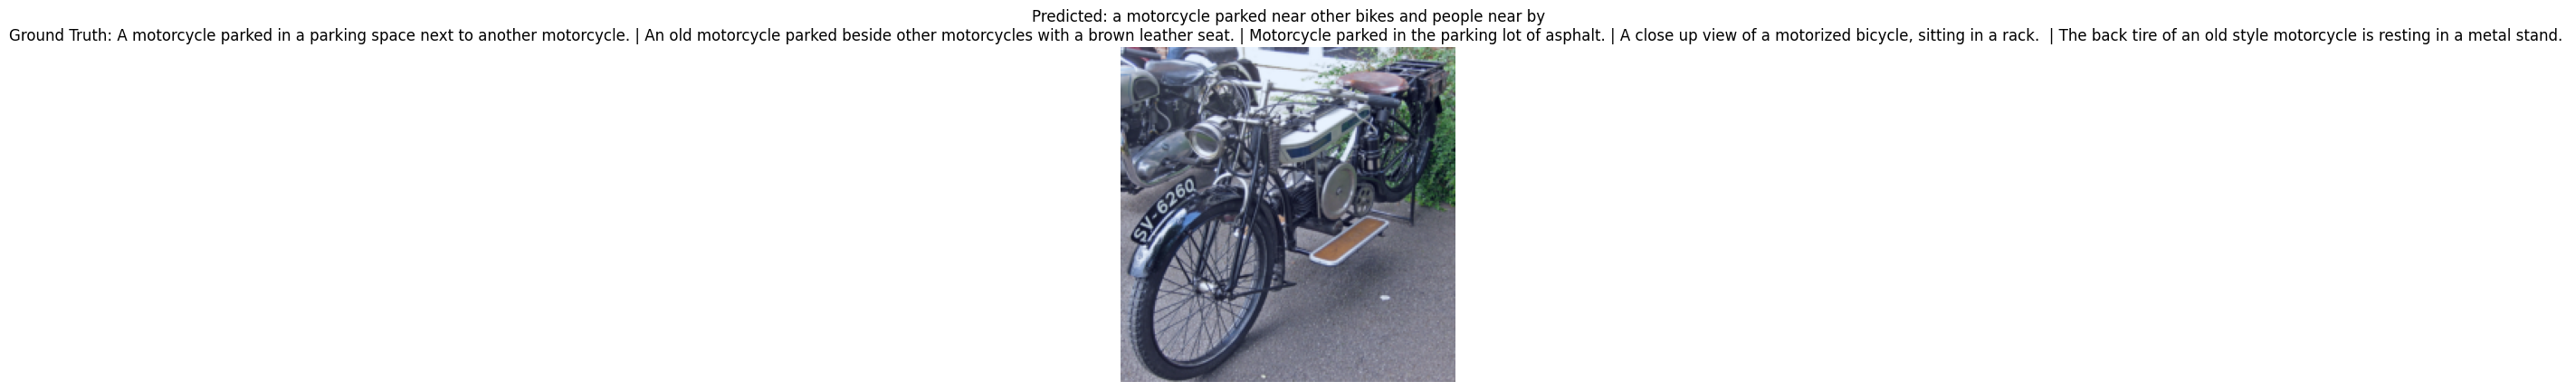

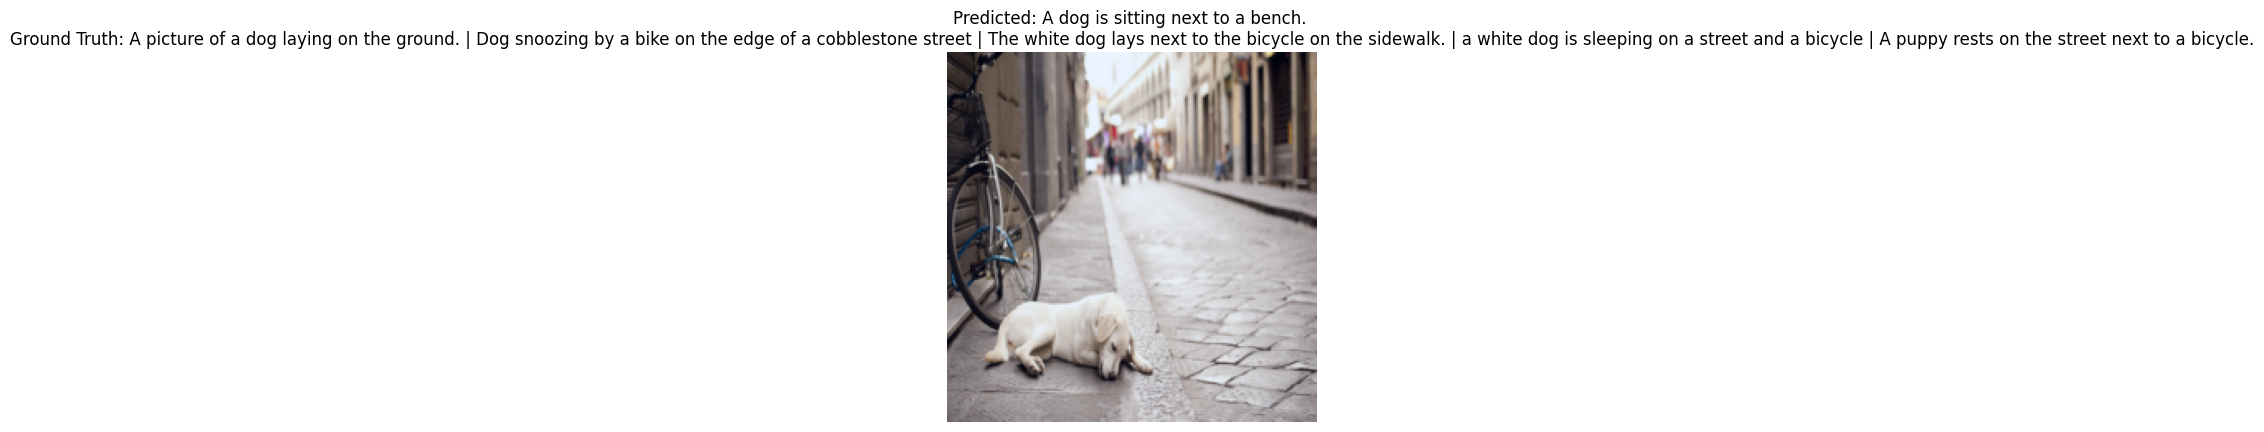

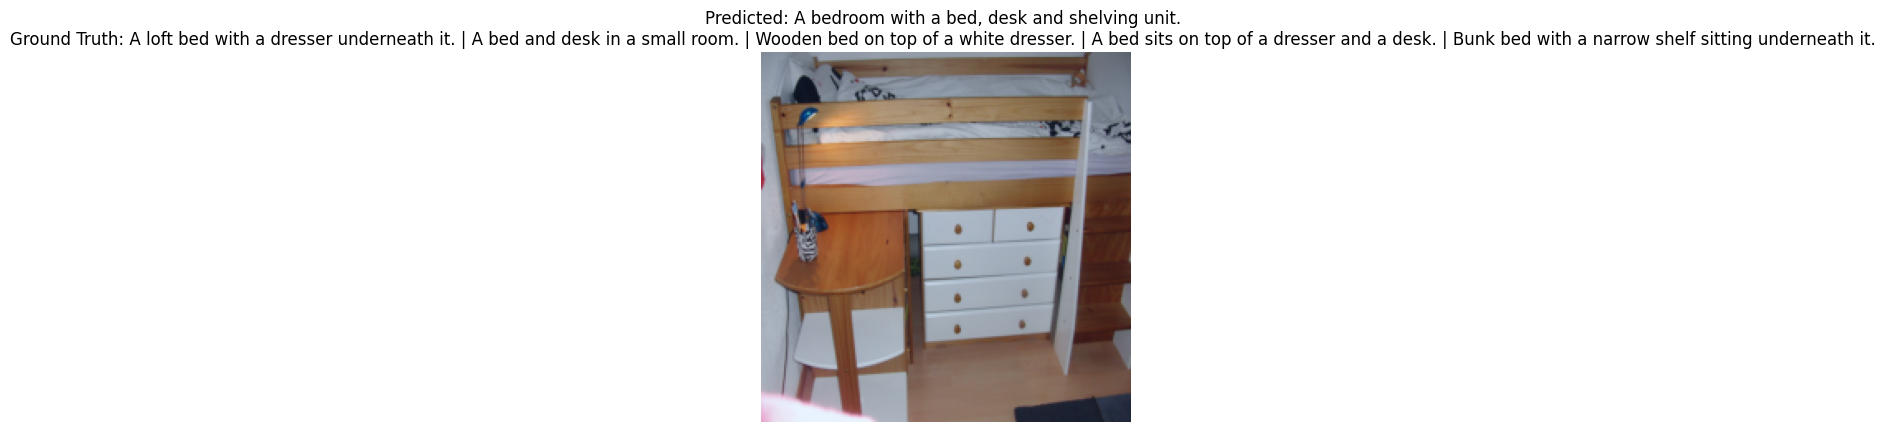

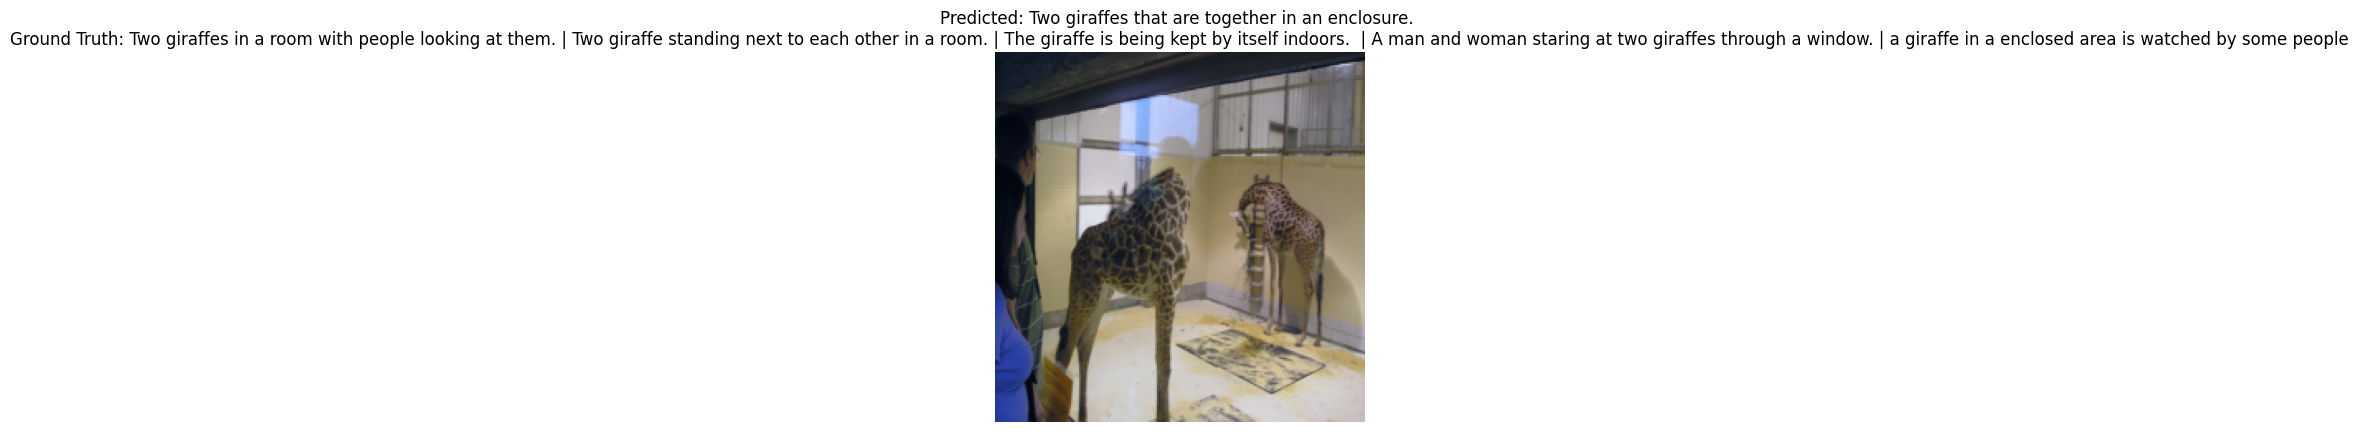

In [53]:

def show_image_with_captions(index, coco_dset, predicted_caption):
    img, target = coco_dset[index]
    img = img.numpy().transpose((1, 2, 0))
    img = (img - img.min()) / (img.max() - img.min())

    plt.imshow(img)
    plt.title(f"Predicted: {predicted_caption}\nGround Truth: {' | '.join(target)}")
    plt.axis('off')
    plt.show()

for i in range(5):
    show_image_with_captions(i, coco_dset, predicted_captions_text[i])
